<a href="https://colab.research.google.com/github/ctorney/moveGP/blob/master/figuresanddiagnostics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import os, sys
import numpy as np
from getpass import getpass
import pickle

import pandas as pd
np.set_printoptions(suppress=True,precision=3)
import matplotlib.pyplot as plt
import matplotlib

plt.style.use('ggplot') 
plt.style.use('seaborn-paper') 
plt.style.use('seaborn-whitegrid') 

data_dir = 'data/'
# code for running in Colab
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    if not os.path.exists("moveGP"):
        user = input('enter GitHub username: ')
        password = getpass('password: ')
        os.environ['git_user'] = user + ':' + password
        
        !git clone https://$git_user@github.com/ctorney/moveGP.git
    
    sys.path.append('moveGP')
    data_dir = 'moveGP/data/'
except Exception:
    pass

import tensorflow as tf
import tensorflow_probability as tfp


# Periodic movement process

In [0]:
df = pd.read_csv(data_dir + '/periodic.csv',index_col=0)
X = df[['Latitude','Longitude']].values
L = df['Lengthscale'].values
A = df['Noise'].values

secs =(pd.to_datetime(df['Date'])- pd.datetime(2000,1,1)).dt.seconds.astype(float).values
days = (pd.to_datetime(df['Date'])- pd.datetime(2000,1,1)).dt.days.astype(float).values

T = (days*24*60+secs/60)/(60*24) 
T = T-T[0]
T=T[:,None]


z_len=720
z_skip=18
Z = T[:z_len:z_skip]
z_len=720

Zp = T[:z_len]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  import sys


In [0]:
n_samples = 2000
num_runs=4

samples = np.zeros((n_samples,num_runs,720))
all_amps = np.zeros(((n_samples)*num_runs,720,1))

for i in range(num_runs):
    amps = np.load(data_dir + '/amps_periodic_' + str(i) + '.npy')
    samples[:,i,:] = amps[:,0]
    
    
    
    all_amps[i*(n_samples):(i+1)*(n_samples),:] = amps


    

In [0]:
samples_ = tf.convert_to_tensor(samples[::])
rhat = tfp.mcmc.diagnostic.potential_scale_reduction(samples_, independent_chain_ndims=1)
rhat.numpy().max()

1.098593912533971

Text(0.5188519965277778, 0.46395833333333336, 'C')

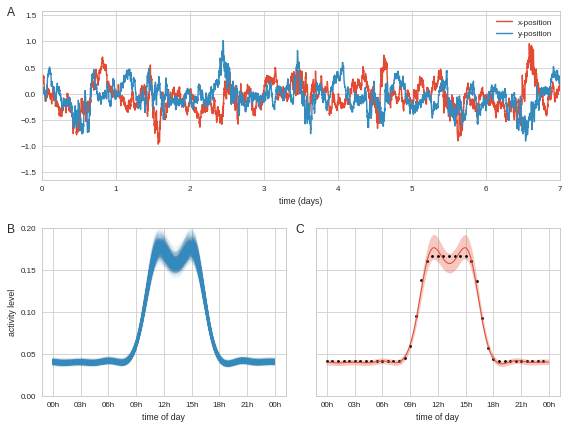

In [0]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

myFmt = mdates.DateFormatter('%Hh')



gridsize = (2, 2)
fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (1, 0))
ax3 = plt.subplot2grid(gridsize, (1, 1))

ax1.plot(T,X[:,0],label='x-position')
ax1.plot(T,X[:,1],label='y-position')
ax1.legend(loc='best')
ax1.set_xlabel('time (days)')
ax1.set_xlim(0,7)



Z_time=np.array([np.datetime64('2019') + np.timedelta64(int(k*24*60*60), 's') for k in Zp])


#plt.plot(T,A,'--',c='k')
for i in range(0,all_amps.shape[0],5):

    ax2.plot(Z_time,all_amps[i],c='C1', alpha=0.025,linewidth=1.0)

ax2.set_ylim(0,0.2)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax2.xaxis_date()

ax2.xaxis.set_major_formatter(myFmt)
#plt.gcf autofmt_xdate()
ax2.set_xlabel('time of day')
ax2.set_ylabel('activity level')


# #plt.plot(Z_time, A[:z_len:z_skip],'--',marker=11,c='k')
ax3.plot(Z_time[::z_skip], A[:z_len:z_skip],".",c='k')

ax3.plot(Z_time, np.mean(all_amps, 0),c='C0', lw=1)

ax3.fill_between(Z_time[:],
                 np.percentile(all_amps, 2.5, axis=0)[:,0],
                 np.percentile(all_amps, 97.5, axis=0)[:,0],
                 color='C0', alpha = 0.3)

# #plt.xlim(0,1)
ax3.set_ylim(0,0.2)

# #plt.xlim(0,1)
# ax = plt.gca()
ax3.xaxis_date()
ax3.yaxis.set_major_locator(ticker.MultipleLocator(0.05))


ax3.xaxis.set_major_formatter(myFmt)
# #plt.gcf autofmt_xdate()
ax3.set_xlabel('time of day')
#ax3.set_ylabel('activity level')
ax3.set_yticklabels([])


plt.tight_layout(h_pad=2,w_pad=3)



xp = ax1.get_position().x0
yp = ax1.get_position().y1    
fig.text(xp - .06, yp- .01, 'A', size=12)

xp = ax2.get_position().x0
yp = ax2.get_position().y1    
fig.text(xp - .06, yp- .01, 'B', size=12)

xp = ax3.get_position().x0
yp = ax3.get_position().y1    
fig.text(xp - .035, yp- .01, 'C', size=12)

#plt.savefig('figures/periodic_combined.png', dpi=300, bbox_inches = "tight")

# Migration shift

In [64]:

df = pd.read_csv(data_dir + '/shift.csv',index_col=0)
X = df[['Latitude','Longitude']].values
L = df['Lengthscale'].values
meanX = df['MeanX'].values
meanY = df['MeanY'].values


secs =(pd.to_datetime(df['Date'])- pd.datetime(2000,1,1)).dt.seconds.astype(float).values
days = (pd.to_datetime(df['Date'])- pd.datetime(2000,1,1)).dt.days.astype(float).values

T = (days*24*60+secs/60)/(60*24) 
T = T-T[0]
T=T[:,None]



z_skip=4
Z = T[::z_skip]

/home/college/ct128w/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
/home/college/ct128w/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  if __name__ == '__main__':


In [65]:
X.shape

(2920, 2)

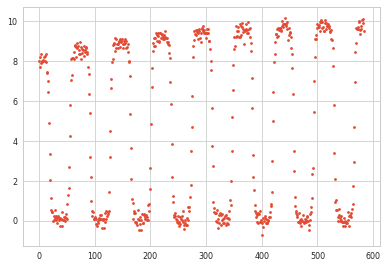

In [66]:
plt.plot(X[::5,1],'.')

In [67]:

n_samples = 2000
samples = np.zeros((n_samples,730*2+3))

for i in range(1):
    
    means = np.load(data_dir + '/mean_shift_' + str(i) + '.npy')

    samples[:,0:730] = means[...,0]
    samples[:,730:1460] = means[...,1]
    lengths = np.load(data_dir + '/length_shift_' + str(i) + '.npy')
    samples[:,1460] = lengths
    amps = np.load(data_dir + '/amp_shift_' + str(i) + '.npy')
    samples[:,1461] = amps
    obs = np.load(data_dir + '/obs_shift_' + str(i) + '.npy')
    samples[:,1462] = obs


ValueError: cannot reshape array of size 292336 into shape (2000,730,2)

In [29]:
ess = tfp.mcmc.effective_sample_size(samples, filter_beyond_positive_pairs=True)

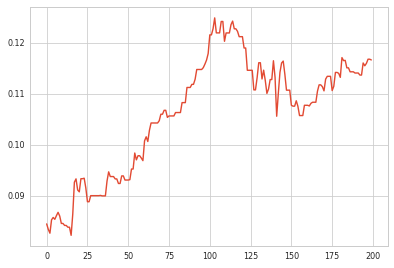

In [52]:
plt.plot(np.sqrt(obs))

In [53]:

num_runs=4

samples = np.zeros((n_samples,num_runs,730*2+3))
all_means = np.zeros(((n_samples)*num_runs,730,2))
all_obs = np.zeros(((n_samples)*num_runs,1))

for i in range(num_runs):
    means = np.load(data_dir + '/mean_shift_' + str(i) + '.npy')

    samples[:,i,0:730] = means[...,0]
    samples[:,i,730:1460] = means[...,1]
    lengths = np.load(data_dir + '/length_shift_' + str(i) + '.npy')
    samples[:,i,1460] = lengths
    amps = np.load(data_dir + '/amp_shift_' + str(i) + '.npy')
    samples[:,i,1461] = amps
    obs = np.load(data_dir + '/obs_shift_' + str(i) + '.npy')
    samples[:,i,1462] = obs
    
    
    all_means[i*(n_samples):(i+1)*(n_samples),...] = means
    all_obs[i*(n_samples):(i+1)*(n_samples),0] = obs

No handles with labels found to put in legend.


Text(0, 0.5, 'x-location')

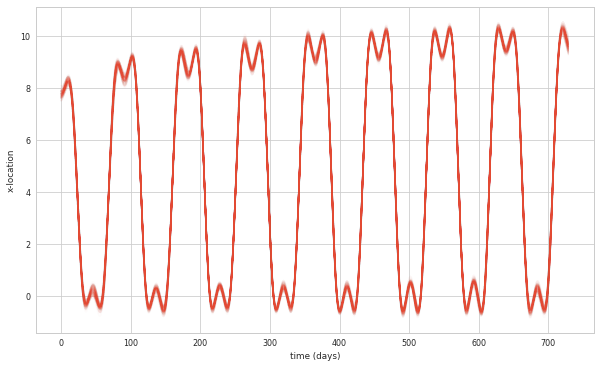

In [55]:
plt.figure(figsize=(10,6))

#plt.plot(T,meanX,'--',c='k')
#plt.plot(means[0,:,1],c='C0', alpha=1.0,linewidth=1.5,label='first')

for i in range(0,means.shape[0]):

    plt.plot(means[i,:,1],c='C0', alpha=0.02,linewidth=1.5)

# for i in range(means.shape[0]-1000,means.shape[0]):

#     plt.plot(means[i,:,1],c='C1', alpha=0.02,linewidth=1.5)


plt.legend()
#plt.xlim(0,1)
plt.xlabel('time (days)')
plt.ylabel('x-location')

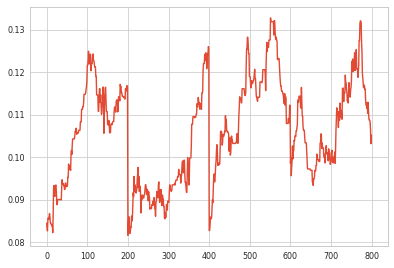

In [56]:
plt.plot(np.sqrt(all_obs))

In [57]:
samples_ = tf.convert_to_tensor(samples[...,:-1])
rhat = tfp.mcmc.diagnostic.potential_scale_reduction(samples_, independent_chain_ndims=1)
rhat.numpy().max()

3.746925426127483

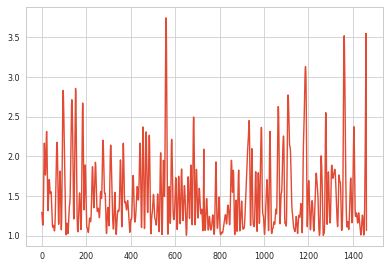

In [58]:
plt.plot(rhat)
#plt.ylim(0,2)

Text(0.04680555555555557, 0.46685185185185185, 'B')

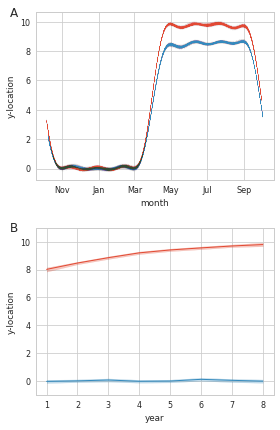

In [49]:

import matplotlib.dates as mdates
import matplotlib.ticker as ticker

myFmt = mdates.DateFormatter('%b')

gridsize = (2, 1)
fig = plt.figure(figsize=(4, 6))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (1, 0))

s1 = 100//z_skip
s2 = 465//z_skip
Z_time=np.array([np.datetime64('2019') + np.timedelta64(int(k), 'D') for k in Z])
Z_time2=np.array([np.datetime64('2019') + np.timedelta64(int(k-365*6), 'D') for k in Z])


for i in range(0,means.shape[0]):
    ax1.plot(Z_time[s1:s2]+180,means[i,s1:s2,1],c='C1', alpha=0.002,linewidth=0.5)

s1 = s1+365*6//z_skip
s2 = s2+365*6//z_skip    

for i in range(0,means.shape[0]):
    ax1.plot(Z_time2[s1:s2]+180,means[i,s1:s2,1],c='C0', alpha=0.002,linewidth=0.5)


#plt.xlim(0,1)
ax1.set_xlabel('month')
ax1.set_ylabel('y-location')




ax1.xaxis.set_major_formatter(myFmt)


meanmean = np.zeros(8)
meanperc1=  np.zeros(8)
meanperc2=  np.zeros(8)

for i in range(8):
    ii = 2+round(i*365/4)
    meanmean[i] = np.mean(means[:,ii,1])
    meanperc1[i] = np.percentile(means[:,ii,1], 2.5, axis=0)
    meanperc2[i] = np.percentile(means[:,ii,1], 97.5, axis=0)
    
ax2.plot(np.arange(1,9), meanmean,c='C0', lw=1)

ax2.fill_between(np.arange(1,9), meanperc1,
                 meanperc2,
                 color='C0', alpha = 0.3)


for i in range(8):
    ii = 2+45+round(i*365/4)
    meanmean[i] = np.mean(means[:,ii,1])
    meanperc1[i] = np.percentile(means[:,ii,1], 2.5, axis=0)
    meanperc2[i] = np.percentile(means[:,ii,1], 97.5, axis=0)
    
ax2.plot(np.arange(1,9), meanmean,c='C1', lw=1)

ax2.fill_between(np.arange(1,9), meanperc1,
                 meanperc2,
                 color='C1', alpha = 0.3)

ax2.set_ylim(-1,11)


ax2.set_xlabel('year')
ax2.set_ylabel('y-location')


plt.tight_layout(h_pad=2,w_pad=3)



xp = ax1.get_position().x0
yp = ax1.get_position().y1    
fig.text(xp - .09, yp- .01, 'A', size=12)

xp = ax2.get_position().x0
yp = ax2.get_position().y1    
fig.text(xp - .09, yp- .01, 'B', size=12)

#plt.savefig('figures/shift_combined.png', dpi=300, bbox_inches = "tight")

# Switching behaviours

In [89]:
df = pd.read_csv(data_dir + '/switch.csv',index_col=0)
X = df[['Latitude','Longitude']].values
ID = df['Animal'].values


secs =(pd.to_datetime(df['Date'])- pd.datetime(2000,1,1)).dt.seconds.astype(float).values
days = (pd.to_datetime(df['Date'])- pd.datetime(2000,1,1)).dt.days.astype(float).values

T = (days*24*60+secs/60)/(60*24) 
T = T-T[0]
T=T[:,None]


uT = np.unique(T)
z_skip=10
Z = uT[::z_skip,None]

/home/college/ct128w/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
/home/college/ct128w/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys


In [91]:
n_samples = 1000
num_runs=4

samples = np.zeros((n_samples,num_runs,148))
all_lengths = np.zeros(((n_samples)*num_runs,147,1))
all_amps = np.zeros(((n_samples)*num_runs,1))

for i in range(num_runs):
    lengths = np.load(data_dir + '/length_switch_' + str(i) + '.npy')
    samples[:,i,:147] = lengths[...,0]
    amps = np.load(data_dir + '/amp_switch_' + str(i) + '.npy')
    samples[:,i,147] = amps
    
    
    all_lengths[i*(n_samples):(i+1)*(n_samples),...] = lengths
    all_amps[i*(n_samples):(i+1)*(n_samples),0] = amps


    
    
    


In [92]:
samples_ = tf.convert_to_tensor(samples[::])
rhat = tfp.mcmc.diagnostic.potential_scale_reduction(samples_, independent_chain_ndims=1)
rhat.numpy().max()

1.8876680057015578

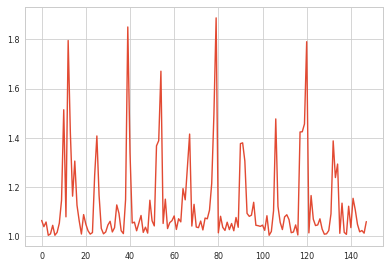

In [93]:
plt.plot(rhat)

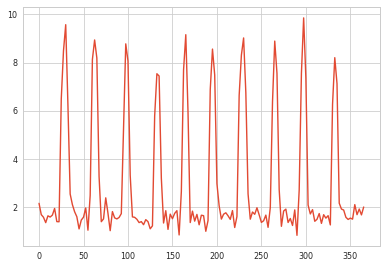

In [39]:
plt.plot(Z,lengths[0,:])



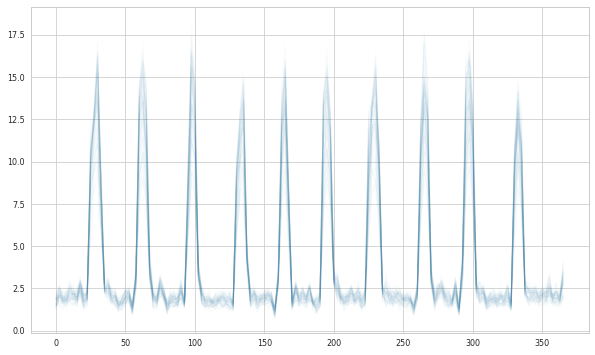

In [46]:
plt.figure(figsize=(10,6))

#plt.plot(T,meanX,'--',c='k')
for i in range(0,all_lengths.shape[0],10):

    plt.plot(Z,all_lengths[i,:],c='C1', alpha=0.02,linewidth=1)
    
plt.show()


Text(0.07371527777777781, 0.2347722694104334, 'C')

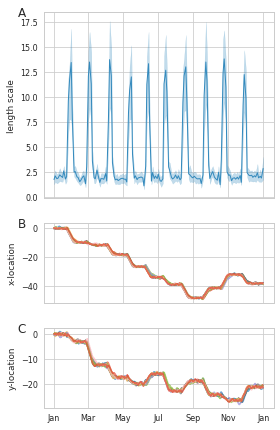

In [41]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

myFmt = mdates.DateFormatter('%b')

#lengths = np.load('data/ls_switch.npy')
#amps = np.load('data/amps_switch.npy')

Z_time=np.array([np.datetime64('2019') + np.timedelta64(int(k), 'D') for k in Z])
T_time=np.array([np.datetime64('2019') + np.timedelta64(int(k), 'D') for k in T])



gridsize = (4, 1)
#fig = plt.figure(figsize=(8, 12))
fig = plt.figure(figsize=(4, 6))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=2)
ax2 = plt.subplot2grid(gridsize, (2, 0))
ax3 = plt.subplot2grid(gridsize, (3, 0))

ax1.plot(Z_time, np.mean(all_lengths, 0),c='C1', lw=1)

ax1.fill_between(Z_time[:],
                 np.percentile(all_lengths, 2.5, axis=0)[:,0],
                 np.percentile(all_lengths, 97.5, axis=0)[:,0],
                 color='C1', alpha = 0.3)

# for i in range(0,lengths.shape[0]):
#     ax1.plot(Z,lengths[i,:],c='C1', alpha=0.002,linewidth=1.5)

ax1.set_ylabel('length scale')    
    
for i in np.unique(ID):
    ax2.plot(T_time[i==ID],X[i==ID,0], alpha=0.7)
ax2.set_ylabel('x-location')    

for i in np.unique(ID):   
    ax3.plot(T_time[i==ID],X[i==ID,1],alpha=0.7)   
    
ax3.set_ylabel('y-location')

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.xaxis.set_major_formatter(myFmt)


plt.tight_layout(h_pad=2,w_pad=3)
xp = ax1.get_position().x0
yp = ax1.get_position().y1    
fig.text(xp - .09, yp- .01, 'A', size=12)

xp = ax2.get_position().x0
yp = ax2.get_position().y1    
fig.text(xp - .09, yp- .01, 'B', size=12)

xp = ax3.get_position().x0
yp = ax3.get_position().y1    
fig.text(xp - .09, yp- .01, 'C', size=12)
